1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [81]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')
from scipy.stats import chi2_contingency

In [46]:
groups = pd.read_csv('groups.csv', sep=';')
group_add = pd.read_csv('group_add.csv', sep=';')
active_studs = pd.read_csv('active_studs.csv', sep=';')
checks = pd.read_csv('checks.csv', sep=';')

In [4]:
active_studs['active'] = True

In [5]:
active_studs = active_studs.rename(columns={'student_id':'id'})
checks = checks.rename(columns={'student_id':'id'})

In [6]:
groups.id.nunique()

74484

In [7]:
checks.id.nunique()

541

In [8]:
active_studs.id.nunique()

8341

In [9]:
# проверим есть ли пользователи, которые не участвуют в эксперименте
data = groups.merge(active_studs, how='outer', on='id').merge(checks, how='outer', on='id')
data.grp.isna().sum()

13

In [10]:
# исключим этих 13 пользователей
data = groups.merge(active_studs, how='left', on='id').merge(checks, how='left', on='id')

In [11]:
data['active'] = data.active.fillna(False)
data['rev'] = data.rev.fillna(0)
data['pay'] = data.rev > 0

In [12]:
control = data.query('grp=="A" and active')
test = data.query('grp=="B" and active')
data_active = data.query('active')

Будем рассчитывать следующие метрики:

Конверсия в покупку (Изменение механики оплаты подразумевает изменение и активности покупок).

Средний доход на активного пользователя (Изменилась ли общая ситуация у активных пользователей)

Средний доход на покупателя (Изменился ли средний чек, стали ли люди оплачивать большее число покупок)

In [13]:
control_cr = control.query('rev > 0').id.count()/control.id.count()*100
control_cr

5.081433224755701

In [14]:
test_cr = test.query('rev > 0').id.count()/test.id.count()*100
test_cr

4.607684380980421

In [15]:
cross_tab = pd.crosstab(data_active.grp, data_active.pay)
cross_tab

pay,False,True
grp,,
A,1457,78
B,6480,313


In [16]:
stat, p, dof, expected = chi2_contingency(cross_tab)
p

0.46803677583199144

Так как p-value больше 0.05, принимаем гипотезу о незначимости различий конверсий в покупку.

In [17]:
control_arpu = control.rev.sum() / len(control)
control_arpu

47.43973941368078

In [18]:
test_arpu = test.rev.sum() / len(test)
test_arpu

57.86456698071545

In [19]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

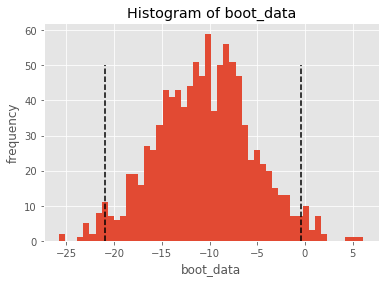

In [49]:
booted_data = get_bootstrap(control.rev, test.rev)

In [50]:
booted_data["p_value"]

0.03746321951855914

Так как p-value оказалось меньше 5% (~3,2%, то есть вероятность получить такие или еще более выраженные различия составит ~3,2%), то отклоняем нулевую гипотезу о равенстве arpu. Различия статистически значимые.

In [51]:
control_arppu = control.query('pay').rev.sum() / len(control.query('pay'))
control_arppu

933.5897435897435

In [52]:
test_arppu = test.query('pay').rev.sum() / len(test.query('pay'))
test_arppu

1255.8274872204472

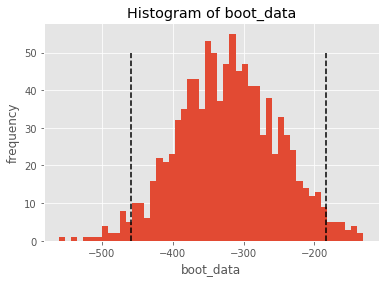

In [53]:
booted_data = get_bootstrap(control.query('pay').rev, test.query('pay').rev)

In [54]:
round(booted_data["p_value"], 5)

1e-05

Так как p-value оказалось меньше 5% (~0.0%, то есть вероятность получить такие или еще более выраженные различия крайне мала), то отклоняем нулевую гипотезу о равенстве arppu. Различия статистически значимы.

Выводы: 
Получили незначимость различий конверсии в покупку и значимость различий ARPU и ARPPU. Можно сказать, что новая механика оказала не оказала влияние на активность переходов активных пользователей в покупку, однако средние чеки выросли, а значит следует запустить механику на всех пользователей.

2.1.
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

SELECT

    COUNT(DISTINCT st_id) as super_students
    
FROM

    (SELECT 
    
        st_id,
        
        toStartOfMonth(timest) as month,
        
        SUM(correct) as correct_tasks
        
FROM peas

WHERE month = '2020-03-01'

GROUP BY 

        st_id,
        
        month
        
HAVING correct_tasks >= 20)


2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

SELECT

    test_grp,
    
    SUM(checks.money)/COUNT(DISTINCT studs.st_id) AS ARPU,
    
    SUM(checks.money)/COUNT(DISTINCT peas.st_id) AS ARPAU,
    
    COUNT(DISTINCT checks.st_id)/COUNT(DISTINCT studs.st_id) AS CR,
    
    COUNT(DISTINCT checks.st_id)/COUNT(DISTINCT peas.st_id) AS CR_activ,
    
    COUNT(math_data.buy_math)/COUNT(math_data.activ_math) AS CR_activ_math
    
FROM studs 

LEFT JOIN peas ON studs.st_id = peas.st_id

LEFT JOIN checks ON studs.st_id = checks.st_id

LEFT JOIN 

    (SELECT
    
        DISTINCT peas.st_id AS math_peas,
    
        peas.subject AS subject,
    
        checks.st_id AS math_pay
    
    FROM peas
    
    LEFT JOIN checks ON math_peas = math_pay
    
    WHERE subject = 'Math') AS math_data ON peas.st_id = math_data.math_peas

GROUP BY test_grp

3. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [119]:
def metrics_with_new_data(path='group_add.csv'):    
    groups = pd.read_csv('groups.csv', sep=';')
    group_add = pd.read_csv(path, sep=',')
    active_studs = pd.read_csv('active_studs.csv', sep=';')
    checks = pd.read_csv('checks.csv', sep=';')
    
    all_data = pd.concat([groups, group_add], axis=0)
    active_studs['active'] = True
    active_studs = active_studs.rename(columns={'student_id':'id'})
    checks = checks.rename(columns={'student_id':'id'})
    all_data = all_data.merge(active_studs, how='outer', on='id').merge(checks, how='outer', on='id')
    all_data['active'] = all_data.active.fillna(False)
    all_data['rev'] = all_data.rev.fillna(0)
    all_data['pay'] = all_data.rev > 0
    control = all_data.query('grp=="A" and active')
    test = all_data.query('grp=="B" and active')
    data_active = all_data.query('active')
    
    control_cr = control.query('rev > 0').id.count()/control.id.count()*100
    test_cr = test.query('rev > 0').id.count()/test.id.count()*100
    control_arpu = control.rev.sum() / len(control)
    test_arpu = test.rev.sum() / len(test)
    df = {'group': ['control', 'test'], 'CR': [control_cr, test_cr], 'ARPU': [control_arpu, test_arpu], 'ARPPU': [control_arppu, test_arppu]}
    metrics = pd.DataFrame(data = df)
    
    return metrics

In [121]:
metrics_with_new_data()

,group,CR,ARPU,ARPPU
0,control,5.071521,47.347204,933.589744
1,test,4.615611,58.058798,1255.827487


In [128]:
def metrics_plot(df):
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (11, 12))
    sns.barplot(x = df['group'], y = df['CR'], ax = ax[0][0], palette="rocket").set_title('CR')
    sns.barplot(x = df['group'], y = df['ARPU'], ax = ax[0][1], palette="rocket").set_title('ARPU')
    sns.barplot(x = df['group'], y = df['ARPPU'], ax = ax[1][0], palette="rocket").set_title('ARPPU')

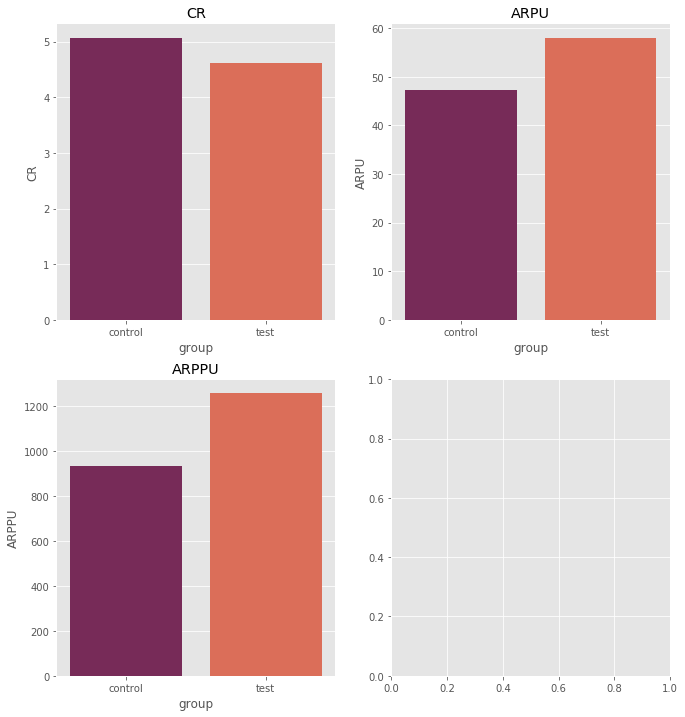

In [129]:
metrics_plot(metrics)